In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

from PIL import Image
from torchvision.utils import make_grid
import os

In [3]:
import sys

sys.path.append("/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/")

from adv_manhole.models import load_models, ModelType
from adv_manhole.attack.losses import AdvManholeLosses
from adv_manhole.attack.naturalness import AdvContentLoss
from adv_manhole.texture_mapping.depth_utils import process_surface_coordinates
from adv_manhole.texture_mapping.depth_mapping import DepthTextureMapping


The console stream is logged into /home/carla_client/sg_logs/console.log


[2024-06-03 09:34:59] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


## Load Dataset

In [4]:
# Load the dataset
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/")
print(carla_dataset)

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})
(720, 1280)


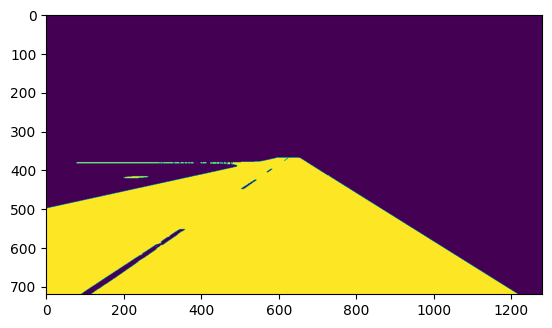

In [5]:
road_masks = np.any(np.array(carla_dataset['train'][0]['semantic']) == np.array((128, 64, 128)), axis=-1) # Road
print(road_masks.shape)
plt.imshow(road_masks.astype(np.float32))
plt.show()

In [32]:
filtered_columns_dataset = carla_dataset.select_columns(
    ["rgb", "raw_depth", "camera_config", "semantic"]
)

data_iterable = {}
batch_size = 8

for data_type, dataset in filtered_columns_dataset.items():
    data_iterable[data_type] = dataset.to_iterable_dataset()
    data_iterable[data_type] = data_iterable[data_type].map(
        lambda example: {
            "local_surface_coors": transforms.ToTensor()(
                process_surface_coordinates(example["raw_depth"], example["camera_config"])
            ),
            "rgb": transforms.ToTensor()(example["rgb"]),
            "road_mask": transforms.ToTensor()(
                np.any(np.array(example['semantic']) == np.array((128, 64, 128)), axis=-1).astype(np.float32)
            ),
        },
        remove_columns=["raw_depth", "camera_config", "semantic"],
    )
    data_iterable[data_type] = DataLoader(
        data_iterable[data_type],
        batch_size=batch_size,
    )

In [7]:
original_index = 0 # Road
# target_indices = list(range(1, 13))  # All classes except Road
target_indices = [3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18]  # Building, Wall, Fence, Pole, Traffic Light, Traffic Sign, Person, Rider, Car, Truck, Bus, Train, Motorcycle, Bicycle

## Load Adversarial Manholes

In [8]:
imsize = 256  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to("cuda", torch.float)

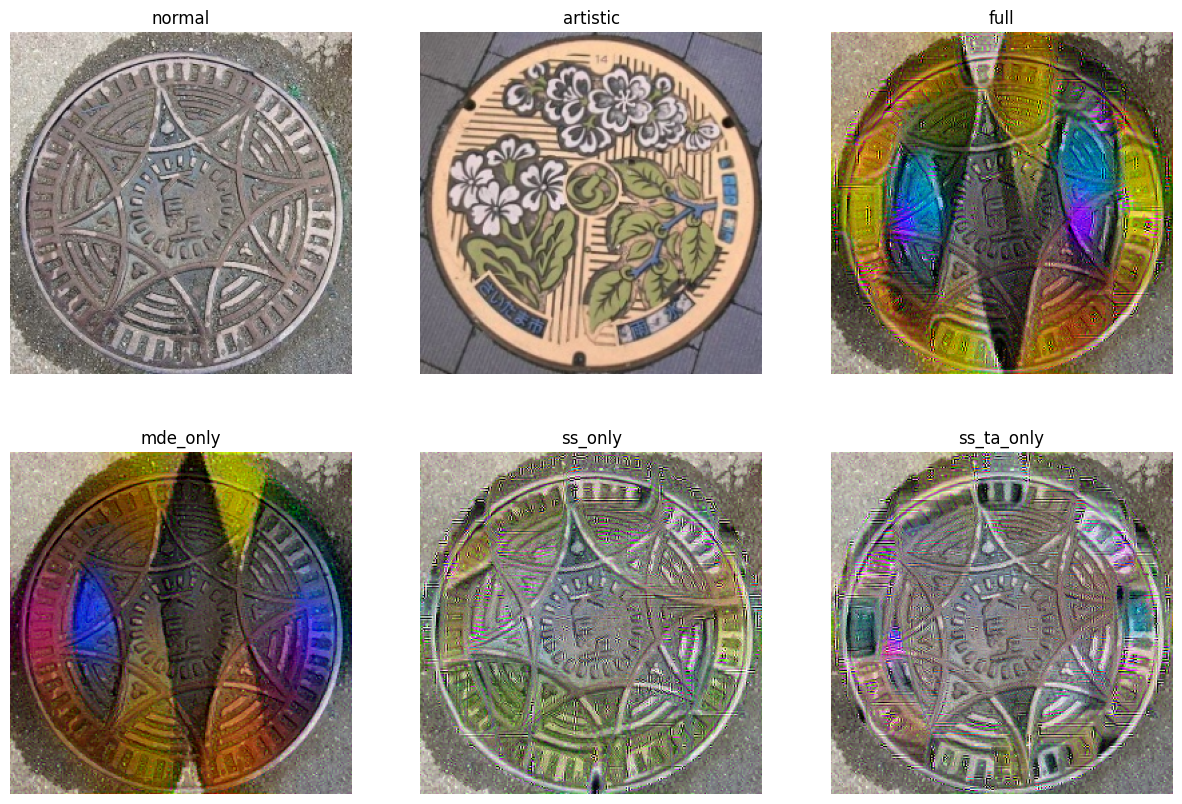

In [9]:
adversarial_manhole_paths = {
    "normal": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/manhole/P1OPDAMV5BDF.jpg',
    "artistic": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/data/artistic_manhole.jpg',
    "full": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle/texture_epoch_24.png',
    "mde_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_mde_only/texture_epoch_24.png',
    "ss_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_ss_only/texture_epoch_24.png',
    "ss_ta_only": '/home/carla_client/workspace/add-aas/aas/personal/adversarial-manhole/notebooks/generated_textures/full_robust_natural_circle_targeted_only/texture_epoch_24.png'
}

# Load the manholes
manhole_images = {}
for key, path in adversarial_manhole_paths.items():
    manhole_images[key] = image_loader(path)

# Plot the manholes
plt.figure(figsize=(15, 10))
for i, (key, image) in enumerate(manhole_images.items()):
    plt.subplot(2, 3, i+1)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.title(key)
    plt.axis('off')
plt.show()

## Load Model

In [10]:
# Load MonoDepth2 model
monodepth2_model = load_models(ModelType.MDE, "mono_640x192")

# Load DDRNet model
ddrnet_model = load_models(ModelType.SS, "ddrnet_23")

/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/carla_client/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2024-06-03 09:35:15] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the cityscapes dataset, published under the following terms: https:/

In [11]:
def error_distance(predicted_disp, original_disp, texture_masks):
    """
    Calculates the error distance between predicted and original depth maps.

    Args:
        predicted_disp (torch.Tensor): Predicted disparity map.
        original_disp (torch.Tensor): Original disparity map.
        texture_masks (torch.Tensor): Texture masks.

    Returns:
        torch.Tensor: Mean error distance between predicted and original depth maps.
    """
    predicted_depth = 1 / (predicted_disp + 1e-6)
    original_depth = 1 / (original_disp + 1e-6)

    error = torch.abs(predicted_depth - original_depth)
    error_masked = error[texture_masks > 0.5]
    return error_masked.mean()

def asr_semantic_segmentation(predicted_semantic, original_index, target_indices, texture_masks):
    """
    Calculate the Attack Success Rate (ASR) for semantic segmentation for both untargeted and targeted attacks.

    Args:
        predicted_semantic: torch.Tensor, shape (N, C, H, W), the predicted semantic segmentation.
        original_index: int, the original class index.
        target_indices: list of int, the target class indices.
        texture_masks: torch.Tensor, shape (N, 1, H, W), the texture masks.

    Returns:
        Tuple of floats, the untargeted ASR and targeted ASR.
    """

    # Get the predicted class indices
    predicted_indices = predicted_semantic.argmax(dim=1)

    # Get the texture masks
    texture_masks = texture_masks.squeeze()

    # Calculate the untargeted ASR
    untargeted_asr = (predicted_indices != original_index).float()
    untargeted_asr = untargeted_asr[texture_masks > 0.5].mean()

    # Calculate the targeted ASR
    targeted_asr = torch.zeros(predicted_indices.shape, device=predicted_indices.device)
    for target_index in target_indices:
        targeted_asr += (predicted_indices == target_index).float()
    targeted_asr = targeted_asr[texture_masks > 0.5].mean()

    return untargeted_asr, targeted_asr

In [37]:
def error_distance_region(predicted_disp, original_disp, texture_masks, road_masks, distance_threshold=0.1):
    """
    Calculate the ratio of error distance region to texture area in road area.

    Args:
        predicted_disp (torch.Tensor, shape (N, 1, H, W)): Predicted disparity map.
        original_disp (torch.Tensor, shape (N, 1, H, W)): Original disparity map.
        texture_masks (torch.Tensor, shape (N, 1, H, W)): Binary mask indicating texture regions.
        road_masks (torch.Tensor, shape (N, 1, H, W)): Binary mask indicating road regions.
        distance_threshold (float, optional): Threshold for error distance. Defaults to 0.1.

    Returns:
        Dict of floats, the error distance mean and ratio.
    """

    # Calculate error distance
    predicted_depth = 1 / (predicted_disp + 1e-6)
    original_depth = 1 / (original_disp + 1e-6)
    error = torch.abs(predicted_depth - original_depth)

    # Error distance masked
    error_masked = error[texture_masks > 0.5]

    # Calculate error distance region
    error_distance_region = (error > distance_threshold).float() * road_masks

    # Calculate the error area for each sample
    error_area = error_distance_region.squeeze(1).sum(dim=(1, 2))

    # Make sure the error area shape is same as batch size
    # assert error_area.shape == road_masks.shape[0], f"Error area shape {error_area.shape} != {road_masks.shape[0]}"

    # Calculate the texture area for each sample
    texture_area = texture_masks.squeeze(1).sum(dim=(1, 2))

    # Make sure the texture area shape is same as batch size
    # assert texture_area.shape == road_masks.shape[0], f"Texture area shape {texture_area.shape} != {road_masks.shape[0]}"

    # Calculate the ratio of error distance region to texture area
    ratio = error_area / texture_area

    return {
        "ed_mean": error_masked.mean(),
        "ed_ratio": ratio.mean()
    }


def asr_segmentation_region(predicted_semantic, original_index, target_indices, texture_masks, road_masks):
    """
    Calculate the Attack Success Rate (ASR) for semantic segmentation for both untargeted and targeted attacks in road area.

    Args:
        predicted_semantic: torch.Tensor, shape (N, C, H, W), the predicted semantic segmentation.
        original_index: int, the original class index.
        target_indices: list of int, the target class indices.
        texture_masks: torch.Tensor, shape (N, 1, H, W), the texture masks.
        road_masks: torch.Tensor, shape (N, 1, H, W), the road masks.

    Returns:
        Dict of floats, the untargeted ASR and targeted ASR in road area.
    """

    # Get the predicted class indices
    predicted_indices = predicted_semantic.argmax(dim=1)

    # Get the texture masks
    texture_masks = texture_masks.squeeze()

    # Get the road masks
    road_masks = road_masks.squeeze()

    # Calculate the untargeted ASR in texture area
    untargeted_asr = (predicted_indices != original_index).float()
    untargeted_asr_mean = untargeted_asr[texture_masks > 0.5].mean()
    
    # Calculate the targeted ASR in texture area
    targeted_asr = torch.zeros(predicted_indices.shape, device=predicted_indices.device)
    for target_index in target_indices:
        targeted_asr += (predicted_indices == target_index).float()
    targeted_asr_mean = targeted_asr[texture_masks > 0.5].mean()

    # Calculate the texture area
    texture_area = texture_masks.squeeze(1).sum(dim=(1, 2))

    # Make sure the texture area shape is same as batch size
    # assert texture_area.shape == road_masks.shape[0]

    # Calculate the rea from untargeted ASR in road area
    untargeted_area = (untargeted_asr * road_masks).squeeze(1).sum(dim=(1, 2))

    # Calculate the ratio of area from targeted ASR in road area
    targeted_area = (targeted_asr * road_masks).squeeze(1).sum(dim=(1, 2))

    # Calculate the ratio of area from untargeted ASR in road area to texture area
    untargeted_ratio = (untargeted_area / texture_area)

    # assert untargeted_ratio.shape == road_masks.shape[0]

    # Calculate the ratio of area from targeted ASR in road area to texture area
    targeted_ratio = targeted_area / texture_area

    # assert targeted_ratio.shape == road_masks.shape[0]

    return {
        "asr_ua_mean": untargeted_asr_mean,
        "asr_ta_mean": targeted_asr_mean,
        "ua_ratio": untargeted_ratio.mean(),
        "ta_ratio": targeted_ratio.mean()
    }

In [13]:
depth_planar_mapping = DepthTextureMapping(
    random_scale=(0.0, 0.01),
    with_circle_mask=True,
    device="cuda",
)

In [36]:
def forward(
        batch, 
        patch_texture = None,
        device = None
    ):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    rgb = batch["rgb"].to(device)
    local_surface_coors = batch["local_surface_coors"].to(device)

    current_batch_size = rgb.shape[0]

    if patch_texture is not None:
        # Repeat the texture to match the batch size
        batched_texture = patch_texture.repeat(
            current_batch_size, 1, 1, 1
        )

        final_images, texture_masks = depth_planar_mapping(
            batched_texture, local_surface_coors, rgb, current_batch_size, random_scale=False, random_shift=False
        )

        # Predict the depth and semantic segmentation
        predicted_disp = monodepth2_model(final_images)
        predicted_semantic = ddrnet_model(final_images)

        return predicted_disp, predicted_semantic, texture_masks

    else:
        # Predict the depth and semantic segmentation
        predicted_disp = monodepth2_model(rgb)
        predicted_semantic = ddrnet_model(rgb)

        return predicted_disp, predicted_semantic, None

In [15]:
train_total_batch = len(filtered_columns_dataset["train"]) // batch_size + 1 if len(filtered_columns_dataset["train"]) % batch_size != 0 else 0
val_total_batch = len(filtered_columns_dataset["validation"]) // batch_size + 1 if len(filtered_columns_dataset["validation"]) % batch_size != 0 else 0
test_total_batch = len(filtered_columns_dataset["test"]) // batch_size + 1 if len(filtered_columns_dataset["test"]) % batch_size != 0 else 0

In [48]:
train_eval_metrics = defaultdict(list)

with tqdm(
    data_iterable['train'], total=train_total_batch, desc=f"Train Evaluation"
) as train_pbar:
    for batch in train_pbar:
        metrics = {}

        road_masks =  batch["road_mask"].cuda()

        with torch.no_grad():
            ori_predicted_disp, ori_predicted_semantic, _ = forward(batch)

            for manhole_name, manhole_image in manhole_images.items():
                # print(key)
                predicted_disp, predicted_semantic, texture_masks = forward(batch, manhole_image)

                # Calculate the error distance
                mde_metrics = error_distance_region(predicted_disp, ori_predicted_disp, texture_masks, road_masks)

                for mde_key in mde_metrics.keys():
                    train_eval_metrics[f"{manhole_name}/{mde_key}"].append(mde_metrics[mde_key].item())

                # Calculate the ASR
                ss_metrics = asr_segmentation_region(predicted_semantic, original_index, target_indices, texture_masks, road_masks)
                for ss_key in ss_metrics.keys():
                    train_eval_metrics[f"{manhole_name}/{mde_key}"].append(ss_metrics[ss_key].item())

            metrics.update({
                key: np.mean(train_eval_metrics[key])
                for key in train_eval_metrics.keys()
            })

                # print(ss_metrics)
                
                # untargeted_asr, targeted_asr = asr_semantic_segmentation(predicted_semantic, original_index, target_indices, texture_masks)
                # train_eval_metrics[key]["asr_ua"].append(untargeted_asr.item())
                # train_eval_metrics[key]["asr_ta"].append(targeted_asr.item())

            # for metric_key in train_eval_metrics.keys():
            #     metrics[f"{key}/{metric_key}"] = np.mean(train_eval_metrics[key][metric_key])


                # metrics.update({
                #     f"{key}/ed": np.mean(train_eval_metrics[key]["ed"]),
                #     f"{key}/asr_ua": np.mean(train_eval_metrics[key]["asr_ua"]),
                #     f"{key}/asr_ta": np.mean(train_eval_metrics[key]["asr_ta"]),
                # })

        train_pbar.set_postfix(metrics)


Train Evaluation:  24%|██▎       | 47/200 [02:43<08:51,  3.47s/it, normal/ed_mean=0.0601, normal/ed_ratio=0.337, artistic/ed_mean=0.103, artistic/ed_ratio=0.503, full/ed_mean=1.05, full/ed_ratio=1.76, mde_only/ed_mean=1.07, mde_only/ed_ratio=0.917, ss_only/ed_mean=0.132, ss_only/ed_ratio=1.39, ss_ta_only/ed_mean=0.131, ss_ta_only/ed_ratio=1.32]

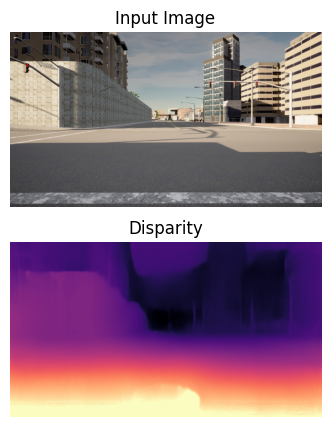

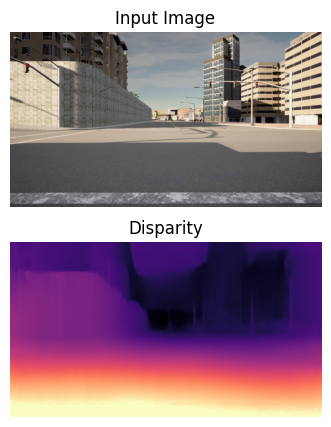

In [18]:
# Plot the depth map
fig = monodepth2_model.plot(batch['rgb'][0].detach().cpu().permute(1, 2, 0), predicted_disp[0])
plt.show()

fig = monodepth2_model.plot(batch['rgb'][0].detach().cpu().permute(1, 2, 0), ori_predicted_disp[0])
plt.show()

In [ ]:
error = torch.abs(predicted_disp - ori_predicted_disp)
print(error.shape)

torch.Size([8, 1, 720, 1280])


In [21]:
# Plot the error map and colorbar for each image
plt.figure(figsize=(15, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(error[i].detach().cpu().squeeze(), cmap='hot')
    plt.colorbar()
    plt.title(f"Error {i}")
    plt.axis('off')

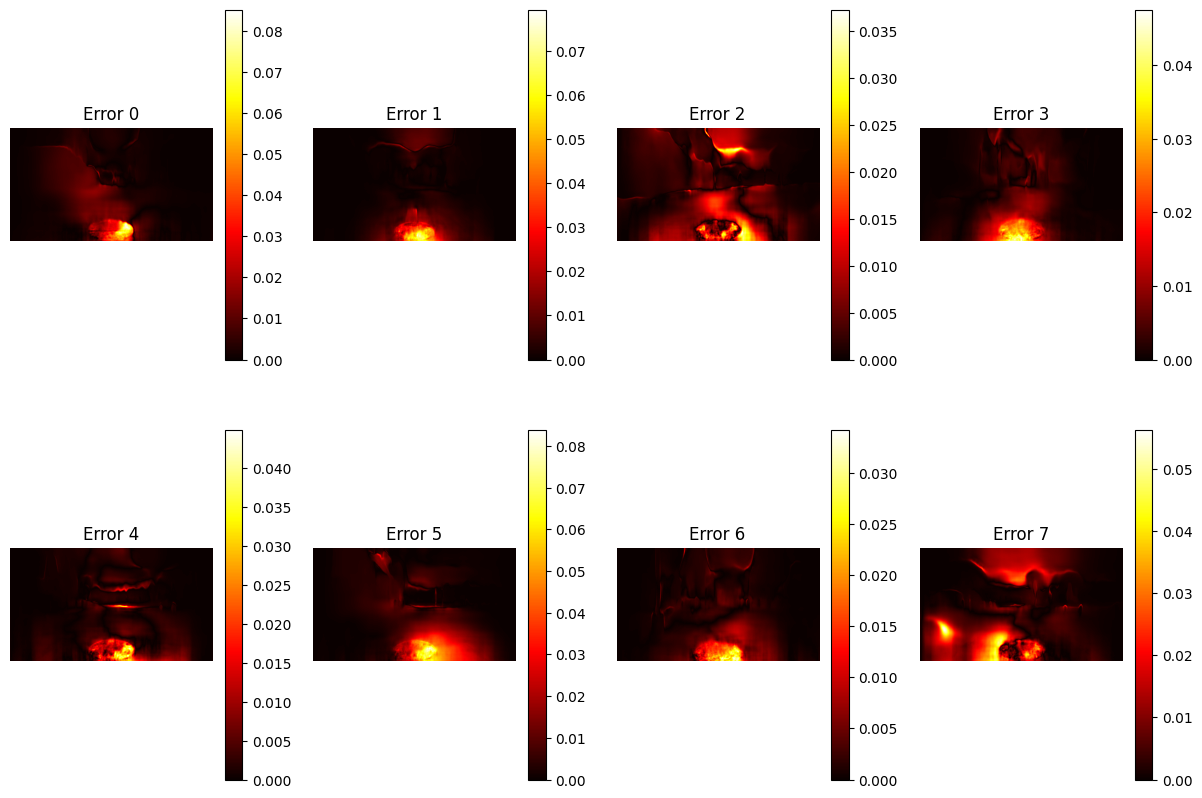

In [22]:
plt.show()